# Neuroevoluce

Pomocí evolučních algoritmů můžeme vyvíjet i celé neuronové sítě. Buď můžeme evolvovat váhy mezi neurony, strukturu sítě, nebo obojí najednou. Nejprve se podíváme, jak naimplementovat jednoduchý algoritmus pro evoluci vah, následně si zkusíme i evoluci vah a struktury sítě dohromady pomocí algoritmu NEAT.

## Evoluce vah

Evoluce vah je jednoduchá, stačí naimplementovat jednoduchou neuronovou síť, které umíme nastavit parametry. Náš jedinec v evoluci bude potom jeden dlouhý vektor, který bude reprezentovat váhy mezi vrstvami v neuronové síti. Při vyhodnocování tedy nastavíme síti váhy podle daného jedince a spočítáme její výstup. Zkusíme si tímto způsobem implementovat klasifikaci na našem oblíbeném datasetu iris.

In [1]:
from sklearn import datasets, model_selection
import numpy as np
import collections
from deap import algorithms, creator, base, benchmarks, cma, tools
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

Začneme tím, že si připravíme jednoduchou implementaci neuronové sítě. Při inicializaci nastavíme vrstvy, jejich velikosti a také jejich aktivace, jelikož každá vrstva může mít svou vlastní aktivační funkci. Dále budeme potřebovat jednoho dlouhého linárního jedince všech vah rozdělit na váhové matice. To uděláme tak, že budeme brát vždy velikost akutální vrstvy a velikost té následující a na základě toho vezmeme odpovídající část jedince a z něj vytvoříme matici vah. Zároveň musíme přidat biasy, takže velikost aktuální vrstvy zvětšíme ještě o 1. Nakonec bude potřeba ještě funkce pro evaluaci sítě, která vytvořenou síť vyhodnotí tak, že pro každou vrstvu použije odpovídající aktivaci a vrátí nám výstup sítě.

In [2]:
class NeuralNetwork: 
    def __init__(self, layer_sizes, activations):
        self.layer_sizes = layer_sizes
        self.layers = None

        # kontrola, zda pocet akivaci sedi na pocet vrstev
        if len(list(activations)) != len(layer_sizes) - 1:
            raise AttributeError("Number of activations does not match number of layers")
        
        self.activations = list(activations)
        self.vectorized_net = None

    # vraci velikosti vahovych matic mezi vrstvami
    def vectorized_size(self):
        return sum(map(lambda x: (x[0] + 1) * x[1], zip(self.layer_sizes, self.layer_sizes[1:])))

    # vezme sit a nastavi hodnoty vahovych matic podle jedince 
    def set_weights(self, vectorized_net):
        
        # kontrola, zda si velikosti odpovidaji
        if len(vectorized_net) != self.vectorized_size():
            raise AttributeError(
                f"Length of vector does not match vectorized_size: {len(vectorized_net)} != {self.vectorized_size()}")

        self.vectorized_net = vectorized_net
        self.layers = []
        sum_sizes = 0
        
        # prochazim vrstvy a beru vzdy aktualni a 1 nasledujici a vyrabim vahove matice tim ze vybiram spravnou cast jedince
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            layer = vectorized_net[sum_sizes: sum_sizes + (p + 1) * n]
            self.layers.append(np.reshape(layer, newshape=(p + 1, n))) # reshape do spravneho tvaru
            sum_sizes += (p + 1) * n # soucet velikosti predchozich vrstev pro indexaci


    # vyhodnoceni site
    def eval_network(self, inputs):
        activations = inputs
        
        for act_func, layer in zip(self.activations, self.layers):
            activations_1 = np.append(np.array([1.0]), activations)  # rozsireni matice vah o konstantu 1.0 pro biasy
            activations = act_func(np.dot(activations_1, layer))

        return activations

Nyní si akorát načteme data a rozdělíme si je na trénovací a testovací.

In [3]:
iris = datasets.load_iris()
train_x, test_x, train_y, test_y = model_selection.train_test_split(iris.data, iris.target)

Musíme si ještě definovat fitness funkci, což bude pouze vyhodnocení sítě na datech, kdy vždy vybereme predikovanou třídu s maximální pravděpodobností a spočítáme pak celkovou accuracy. Zároveň si definujeme vlastní lineární a relu aktivace.

In [4]:
def relu(x):
    return np.maximum(0,x)

def linear(x):
    return x

def fitness(ind, X, y):
    net.set_weights(ind)
    
    acc = 0
    for xi, yi in zip(X, y):
        if np.argmax(net.eval_network(xi)) == yi:
            acc += 1
    
    return acc/len(y),

Pro samotné nastavení vah neuronové sítě použíjeme algoritmus CMA-ES, což je evoluční strategie, která je dobrá na úlohy spojité optimalizace, kterou máme i zde. V evoluční strategii se nevyskytuje křížení, ale místo něj se klade důraz na mutaci. Zde se používá námi známá gaussovská mutace. Evoluční strategii používáme také proto, že nám umožňuje váhy měnit korelovaně, protože si pamatuje celou kovariační matici, ze které generuje jedince. Klasická evoluce umí měnit váhy jen nezávisle na sobě, a dává proto horší výsledky. CMA-ES je implementována v knihovně deap, a je tedy snadné ji použít.

In [5]:
net = NeuralNetwork([4, 5, 3], [relu, linear])
ind_size = net.vectorized_size()    
    
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("evaluate", fitness, X=train_x, y=train_y)

strategy = cma.Strategy(centroid=[0.0]*ind_size, sigma=0.1, lambda_=5*ind_size)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

_ = algorithms.eaGenerateUpdate(toolbox, ngen=111, stats=stats, halloffame=hof)

gen	nevals	avg     	std      	min	max     
0  	215   	0.337915	0.0907846	0  	0.642857
1  	215   	0.340532	0.0940187	0  	0.669643
2  	215   	0.352159	0.0964198	0  	0.669643
3  	215   	0.356105	0.1136   	0  	0.669643
4  	215   	0.348422	0.095926 	0  	0.669643
5  	215   	0.356478	0.105597 	0  	0.678571
6  	215   	0.352575	0.117176 	0  	0.946429
7  	215   	0.359012	0.119006 	0  	0.741071
8  	215   	0.353821	0.10323  	0  	0.669643
9  	215   	0.368439	0.109386 	0  	0.669643
10 	215   	0.373131	0.120655 	0  	0.714286
11 	215   	0.391736	0.106726 	0.258929	0.767857
12 	215   	0.411213	0.135155 	0.0178571	0.821429
13 	215   	0.417317	0.143736 	0.0535714	0.839286
14 	215   	0.416819	0.14032  	0.0357143	0.866071
15 	215   	0.431728	0.146417 	0.116071 	0.955357
16 	215   	0.439535	0.150615 	0        	0.910714
17 	215   	0.441694	0.158446 	0.0535714	0.9375  
18 	215   	0.442982	0.144582 	0.0625   	0.696429
19 	215   	0.450249	0.147669 	0.0267857	0.8125  
20 	215   	0.471512	0.158143 	0        	0.91

Na závěr si zkusíme otestovat síť na testovacích datech a změřit na nich accuracy.

In [6]:
fitness(hof[0], test_x, test_y)

(0.9473684210526315,)

## NEAT

Zkusíme se podívat na algoritmus NEAT na příkladu s datasetem iris a zkusíme pro něj najít nejvhodnější síť, která bude umět data nejlépe klasifikovat. Samotná implementace algorimtu není vůbec jednoduchá, ale naštěstí v pythonu existuje knihovna neat-python, kde už tu práci někdo udělal za nás. Knihovna má trochu jiný interface, než na co jsme zvyklí, ale není složité se ji naučit používat. Nastavení parametrů algoritmu se načítá ze zvláštního souboru *config-feedforward*. Dokumentace k jeho formátování se nachází [zde](https://neat-python.readthedocs.io/en/latest/config_file.html). Potom už stačí jen algoritmus spustit. Níže uvedený příklad vychází z dokumentace k [neat-python](https://github.com/CodeReclaimers/neat-python/tree/master/examples/xor) upravený pro naši klasifikaci irisů.


 ****** Running generation 0 ****** 

Population's average fitness: 36.24000 stdev: 13.76453
Best fitness: 75.00000 - size: (3, 12) - species 1 - id 74
Average adjusted fitness: 0.483
Mean genetic distance 1.227, standard deviation 0.246
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150     75.0    0.483     0
Total extinctions: 0
Generation time: 0.263 sec

 ****** Running generation 1 ****** 

Population's average fitness: 40.16000 stdev: 13.24944
Best fitness: 75.00000 - size: (3, 12) - species 1 - id 74
Average adjusted fitness: 0.535
Mean genetic distance 1.312, standard deviation 0.279
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150     75.0    0.535     1
Total extinctions: 0
Generation time: 0.260 sec (0.262 average)

 ****** Running generation 2 ****** 

Population's average fitness: 40.50667 

Population's average fitness: 56.34000 stdev: 18.82758
Best fitness: 105.00000 - size: (3, 9) - species 1 - id 985
Average adjusted fitness: 0.305
Mean genetic distance 1.833, standard deviation 0.386
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   17    57    105.0    0.305    11
     2    5    93     92.0    0.305     0
Total extinctions: 0
Generation time: 0.307 sec (0.308 average)

 ****** Running generation 18 ****** 

Population's average fitness: 52.36000 stdev: 18.45329
Best fitness: 105.00000 - size: (3, 9) - species 1 - id 985
Average adjusted fitness: 0.253
Mean genetic distance 1.802, standard deviation 0.399
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18    74    105.0    0.230    12
     2    6    76    101.0    0.276     0
Total extinctions: 0
Generation time: 0.302 sec (0.312 average)

 ****** Runni

Population's average fitness: 57.63333 stdev: 19.23588
Best fitness: 106.00000 - size: (3, 7) - species 1 - id 4574
Average adjusted fitness: 0.318
Mean genetic distance 1.734, standard deviation 0.345
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   34    92    106.0    0.331     2
     2   22    58    106.0    0.304     3
Total extinctions: 0
Generation time: 0.269 sec (0.271 average)

 ****** Running generation 35 ****** 

Population's average fitness: 56.90667 stdev: 19.07226
Best fitness: 106.00000 - size: (3, 7) - species 1 - id 4574
Average adjusted fitness: 0.435
Mean genetic distance 1.780, standard deviation 0.332
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   35    75    106.0    0.408     3
     2   23    75    106.0    0.462     4
Total extinctions: 0
Generation time: 0.242 sec (0.268 average)

 ****** Run

Population's average fitness: 62.84000 stdev: 20.30077
Best fitness: 110.00000 - size: (4, 10) - species 2 - id 7255
Average adjusted fitness: 0.554
Mean genetic distance 2.426, standard deviation 0.565
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   50    69    110.0    0.567     7
     2   38    81    110.0    0.540     4
Total extinctions: 0
Generation time: 0.281 sec (0.291 average)

 ****** Running generation 51 ****** 

Population's average fitness: 63.83333 stdev: 20.21399
Best fitness: 110.00000 - size: (5, 10) - species 1 - id 6897
Average adjusted fitness: 0.385
Mean genetic distance 2.493, standard deviation 0.578
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   51    59    110.0    0.390     8
     2   39    91    110.0    0.380     5
Total extinctions: 0
Generation time: 0.270 sec (0.293 average)

 ****** R

Population's average fitness: 63.66000 stdev: 23.17177
Best fitness: 110.00000 - size: (4, 10) - species 2 - id 7255
Average adjusted fitness: 0.384
Mean genetic distance 2.170, standard deviation 0.692
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   66    42    110.0    0.347    23
     2   54    50    110.0    0.358    20
     3   10    58    105.0    0.447     9
Total extinctions: 0
Generation time: 0.252 sec (0.287 average)

 ****** Running generation 67 ****** 

Population's average fitness: 64.88667 stdev: 22.05494
Best fitness: 110.00000 - size: (4, 10) - species 2 - id 7255
Average adjusted fitness: 0.420
Mean genetic distance 2.125, standard deviation 0.774
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   67    44    110.0    0.398    24
     2   55    43    110.0    0.439    21
     3   11    63    105.0    0.

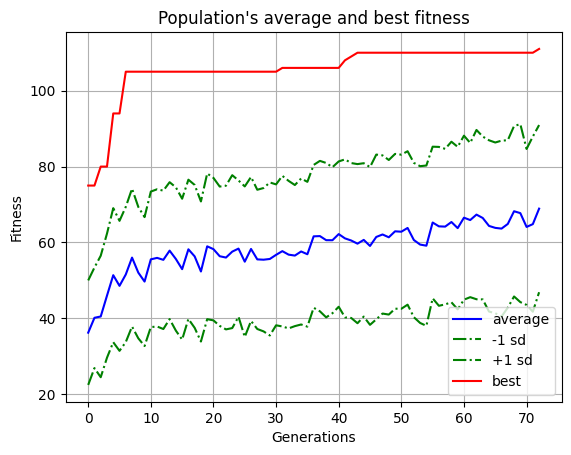

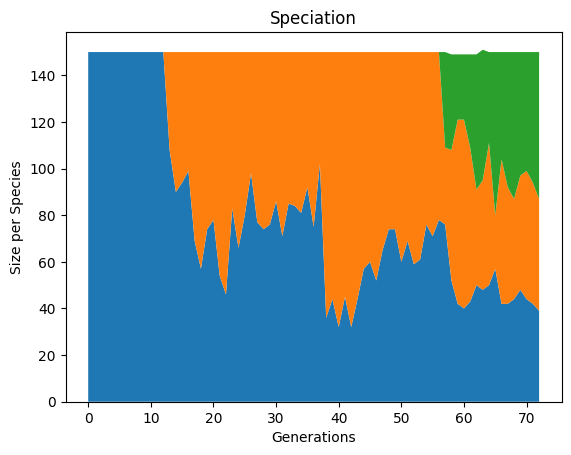

In [7]:
import neat
import visualize
import os

# vytvoreni a vyhodnoceni site v neatu - fitness funkce
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0.0
        net = neat.nn.FeedForwardNetwork.create(genome, config) 
        for xi, xo in zip(train_x, train_y): 
            output = net.activate(xi)
            if np.argmax(output) == xo:
                genome.fitness += 1

def run(config_file):
    
    # nacteme konfiguraci neatu 
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    # vytvorime novou populaci
    p = neat.Population(config)

    # pridame statisticke vypocty pro logovani evoluce    
    p.add_reporter(neat.StdOutReporter(show_species_detail=True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    
    # pustime pro dany pocet generaci
    winner = p.run(eval_genomes, 100)

    # zobrazime nejlepsiho jedince a jeho vystup
    print('\nBest genome:\n{!s}'.format(winner))
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(train_x, train_y):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    # vykresluje nejlepsi sit
    node_names = {-1:'x1', -2: 'x2', -3: 'x3', -4: 'x4', 0:'setosa', 1:'virginica', 2:'versicolor'}
    visualize.draw_net(config, winner, True, node_names=node_names) 
    visualize.plot_stats(stats, ylog=False, view=True)
    visualize.plot_species(stats, view=True)

    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    #p.run(eval_genomes, 10)

if __name__ == '__main__':
    # urceni cesty ke konfiguracnimu souboru
    config_path = os.path.join('.', 'config-feedforward')
    run(config_path)

Výsledná architektura neuronové sítě pak může vypadat například takto:


## Úkol na cvičení

Zkuste si pohrát s NEATem a vyskoušet si ho třeba na OpenAI Gym, který jsme dělali na druhém cvičení. Bude potřeba upravit  fitness funkci, tedy místo accuracy dát odměnu za hru, a také bude potřeba změnit pár věcí v konfiguračním souboru, například parametry počáteční sítě a podmínky, kdy má algoritmus skončit. [Zde](https://github.com/CodeReclaimers/neat-python/tree/master/examples/openai-lander) je pro inspiraci vyřešený [LunarLander](https://gym.openai.com/envs/LunarLander-v2/). Můžete si vybrat libovolný z [problémů](https://gym.openai.com/envs/#classic_control) z knihovny gym a zkusit vytvořit a natrénovat neuronovou síť pomocí neuroevoluce. 

Pro začátek doporučuji použít kód ze [druhého cvičení](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/02_zpetnovazebne_uceni/reinforcement_learning.ipynb), jen místo trénování pomocí agenta s Q-učením použijeme algoritmus NEAT. Pak už je jen potřeba vymyslet fitness funkci a upravit si vhodně jedince v evolučním algoritmu.